In [1]:
import cv2
import spacy
import json
import cv2
import matplotlib.pyplot as plt
import sys

In [2]:
def preprocess_image(image):
    # Check if the image is grayscale
    if len(image.shape) == 2 or image.shape[2] == 1:  # If grayscale
        # Convert grayscale image to 3-channel grayscale (to mimic RGB)
        image_gray = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        # If already a 3-channel image, just use it
        image_gray = image

    # Apply CLAHE to enhance contrast
    lab = cv2.cvtColor(image_gray, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    enhanced_image = cv2.merge((cl, a, b))
    enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_LAB2BGR)

    # Optionally, increase the brightness
    beta = 30  # Brightness control (0-100)
    brightened_image = cv2.convertScaleAbs(enhanced_image, alpha=1, beta=beta)

    return brightened_image

def detect_face(image):
    from mtcnn import MTCNN
    detector = MTCNN()
    faces = detector.detect_faces(image)
    del(detector)
    del sys.modules['mtcnn']
    return faces

def extract_face(image, im2):
    faces = detect_face(image)
    if len(faces) > 0:
        # Use the first detected face
        face = faces[0]
        x, y, width, height = face['box']
        cropped_face = im2[y:y+height, x:x+width]
        return cropped_face
    else:
        return None  

def extract_info_ner(text):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    info = {}

    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            info['name'] = ent.text
        elif ent.label_ == 'DATE':
            info['dob'] = ent.text
        elif ent.label_ == 'CARDINAL':  # For things like passport numbers
            info['passport_number'] = ent.text
    
    return info

def text_extraction(image):
    import pytesseract
    text = pytesseract.image_to_string(image)
    del sys.modules['pytesseract']
    extracted_text = extract_info_ner(text)
    return extracted_text
    
def process_image(image):
    image_copy = image.copy()
    preprocessed_image = preprocess_image(image)
    face = extract_face(preprocessed_image, image_copy)
    text = text_extraction(image_copy)
    
    json_string = json.dumps(text)
    #print(json_string)
    return face, json_string


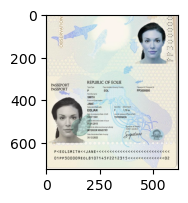

2024-08-27 14:30:32.629053: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-08-27 14:30:32.629078: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-08-27 14:30:32.629082: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-08-27 14:30:32.629098: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-27 14:30:32.629110: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-08-27 14:30:33.190245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


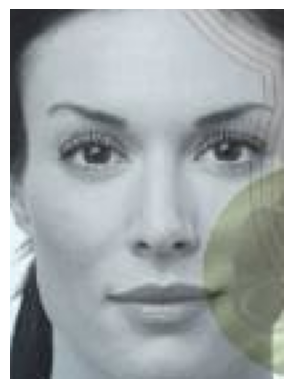

{"name": "erica"}


In [3]:
# Load the image
filepath = '/Users/chirasthit/Developer/Data Science/Rootcode TT/passport_rec/test_images/p30.jpeg'
image = cv2.imread(filepath)
plt.figure(figsize=(2,2))
plt.imshow(image)
plt.show()

if image is not None:
    face, data = process_image(image)

    if face is not None:
        plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    else:
        print("No face detected.")
    
    print(data)
else:
    print("Image not found. Please check the file path.")